# Парето-оптимальность, Selenium и отели в Пекине

Название [моего блога](https://vk.com/mat.chast) как бы намекает, что его содержание применимо в быту. К сегодняшнему блокноту это точно относится: он про выбор отелей. 

Моя подруга на новогодние праздники собралась в Пекин, и для этого решила выбрать отель. В Пекине их тысяча, и она ограничила поиск только пятизвёздочными. Но даже таких отелей там больше сотни, и из них хочется выбрать наилучший по соотношению цена-качество.

Сколько можно заплатить за дополнительный балл оценки (она измеряет качество)? На этот вопрос ответ у каждого свой. Но чтобы не перебирать вручную 150 отелей, можно заставить алгоритм отобрать с десяток отелей, каждый из которых был бы лучшим в своей ценовой категории. В математике такие отели называются Парето-оптимальными.

А раз уж мы всё равно пользуемся алгоритмом, почему бы не распарсить booking.com тоже полностью автоматически?

Именно этому - парсингу booking.com и выбору оптимального отеля - и посвящён блокнот. 

# Сбор данных при помощи Selenium

Предполагается, что:
* у вас установлены все необходимые питоновские пакеты. Если какой-то импорт не работает, зовите pip install
* у вас установлен Firefox (если не хотите его ставить, попробуйте другой бразуер, но к нему нужен свой драйвер)
* у вас есть geckodriver, скачанный отсюда https://github.com/mozilla/geckodriver/releases и распакованный
* этот geckodriver находится в той же папке, что и блокнот (либо добавлен в PATH)

Если вам лень заниматься всей этой технической частью, можете скачать данные и сразу перейти к их анализу. 

In [1]:
from selenium import webdriver

In [2]:
driver = webdriver.Firefox() 

In [3]:
url = "https://www.booking.com/searchresults.ru.html?label=gen173nr-1FCAEoggJCAlhYSDNYBGjCAYgBAZgBIcIBCndpbmRvd3MgMTDIAQzYAQHoAQH4AQuSAgF5qAID&sid=6b8e3d83b69499330279412a904e1bd4&checkin_month=1&checkin_monthday=4&checkin_year=2018&checkout_month=1&checkout_monthday=11&checkout_year=2018&class_interval=1&dest_id=-1898541&dest_type=city&dtdisc=0&from_sf=1&group_adults=2&group_children=0&inac=0&index_postcard=0&label_click=undef&no_rooms=1&oos_flag=0&postcard=0&room1=A%2CA&sb_price_type=total&search_pageview_id=2f838df472d401ec&src=index&ss=Пекин&ss_all=0&ssb=empty&sshis=0&nflt=class%3D5%3B&lsf=class%7C5%7C124&unchecked_filter=class"

In [12]:
driver.get(url)

In [13]:
def get_data_from_hotel(div):
    name = div.find_elements_by_css_selector('span.sr-hotel__name')[0].text
    
    rating_elements =  div.find_elements_by_css_selector('span.review-score-badge')
    if rating_elements:
        rating = rating_elements[0].text
    else:
        rating = 0
    
    price_elements = price = div.find_elements_by_css_selector('strong.price')
    if price_elements:
        price = price_elements[0].text
    else:
        price = None
    
    hotel = {'name':name, 'price': price, 'rating': rating}
    return hotel

In [14]:
hotels = []

In [15]:
for div in driver.find_elements_by_css_selector('div.sr_item'):
    hotel = get_data_from_hotel(div)
    print(hotel)
    hotels.append(hotel)

{'name': 'New World Beijing Hotel', 'price': '46 554 руб.', 'rating': '9,1'}
{'name': 'Beijing Prime Hotel Wangfujing', 'price': '30 160 руб.', 'rating': '8,0'}
{'name': 'Hotel Cote Cour Beijing', 'price': None, 'rating': '9,2'}
{'name': 'Grand Millennium Beijing', 'price': '54 748 руб.', 'rating': '8,5'}
{'name': 'The Emperor Beijing Qianmen', 'price': '43 620 руб.', 'rating': '8,0'}
{'name': 'Legendale Hotel Beijing', 'price': '63 838 руб.', 'rating': '9,0'}
{'name': 'NUO Hotel Beijing', 'price': '64 629 руб.', 'rating': '9,2'}
{'name': 'Sunworld Dynasty Hotel Beijing', 'price': '39 372 руб.', 'rating': '8,0'}
{'name': 'Beijing Hotel NUO Wangfujing', 'price': '45 401 руб.', 'rating': '8,7'}
{'name': 'Beijing Marriott Hotel City Wall', 'price': None, 'rating': '8,0'}
{'name': 'Swissotel Beijing Hong Kong Macau Center', 'price': '37 077 руб.', 'rating': '8,0'}
{'name': 'The Imperial Mansion, Beijing - Marriott Executive Apartments', 'price': '61 068 руб.', 'rating': '8,7'}
{'name': 'Ho

Находим и жмём кнопку "дальше". Потом надо ждать, но непонятно, сколько. 

Давайте проверять раз в секунду, а через 10 секунд, если не загрузилось, жалуемся, что всё отваливается. 

In [16]:
import time

for page in range(100):
    bottom = driver.find_elements_by_css_selector('div.results-meta')[0]
    print(bottom.find_elements_by_css_selector('h4')[0].text)
    buttons = driver.find_elements_by_css_selector('a.paging-next')
    if buttons:
        buttons[0].click()
        time.sleep(3)
        for div in driver.find_elements_by_css_selector('div.sr_item'):
            hotel = get_data_from_hotel(div)
            hotels.append(hotel)
    else:
        break

Пекин: найдено 124 варианта показаны 1 – 30
Пекин: найдено 124 варианта показаны 31 – 60
Пекин: найдено 124 варианта показаны 61 – 90
Пекин: найдено 124 варианта показаны 91 – 120
Пекин: найдено 124 варианта показаны 121 – 142


In [17]:
print(len(hotels))

158


# Анализ данных

Классический импорт библиотек

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Если вы не собирали данные Селениумом, самое время скачать их отсюда и положить в ту же папку, что и блокнот. 

In [69]:
try:
    hotels = pickle.load(open('hotels.pkl', 'rb'))
except FileNotFoundError:
    print('Если вы собрали данные, пропустите эту ячейку. Иначе скачайте их и попробуйте снова.')

In [21]:
data = pd.DataFrame(hotels)
data.head()

,name,price,rating
0,New World Beijing Hotel,46 554 руб.,"9,1"
1,Beijing Prime Hotel Wangfujing,30 160 руб.,"8,0"
2,Hotel Cote Cour Beijing,None,"9,2"
3,Grand Millennium Beijing,54 748 руб.,"8,5"
4,The Emperor Beijing Qianmen,43 620 руб.,"8,0"


Сейчас цена и рейтинг - это текстовые строки. Превратим их в числа:

In [32]:
data.rating = data.rating.str.replace(',', '.').astype(float)
data.price = data.price.str.replace('руб.', '').str.replace(' ', '').astype(float)

Теперь данные можно визуализировать

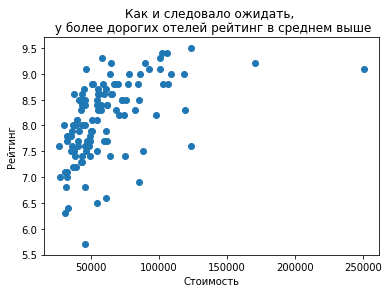

In [64]:
plt.scatter(data.price, data.rating)
plt.xlabel('Стоимость')
plt.ylabel('Рейтинг')
plt.title('Как и следовало ожидать, \n у более дорогих отелей рейтинг в среднем выше');

Теперь найдем Парето-оптимальные отели.

Напомним, что отель называется Парето-оптимальным, если никакой другой отель его не доминирует. 

Мы говорим, что отель A доминирует Б, если A не хуже Б ни по цене, ни по качеству, и хотя бы по одному из параметров А строго лучше. 

In [49]:
optimal = []
for idx, hotel in data.sort_values('price').iterrows():
    better = data[(data.price <= hotel.price) & (data.rating >= hotel.rating)]
    if better.price.min() == hotel.price and better.rating.max() == hotel.rating:
        optimal.append(hotel)
optimal = pd.DataFrame(optimal)
optimal

,name,price,rating
25,Jingtailong International Hotel,26985.0,7.6
1,Beijing Prime Hotel Wangfujing,30160.0,8.0
18,Beijing Qianyuan Hotel,37887.0,8.6
8,Beijing Hotel NUO Wangfujing,45401.0,8.7
0,New World Beijing Hotel,46554.0,9.1
29,Shichahai Sandalwood Boutique Hotel Beijing,58181.0,9.3
129,Zhaolin Grand Hotel,102196.0,9.4
27,Rosewood Beijing,123717.0,9.5


Именно эти 8 отелей обеспечивают лучшее соотношение цена-качество. 

Все остальные отели хуже какого-либо из Парето-оптимальных или по цене, или по качеству, или по тому и другому. 

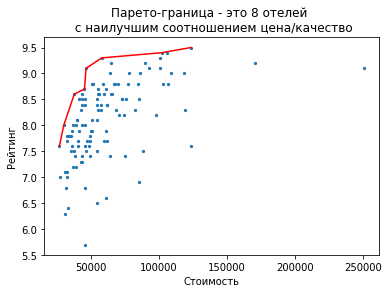

In [62]:
plt.scatter(data.price, data.rating, s=5);
plt.plot(optimal.price, optimal.rating, color = 'red')
plt.xlabel('Стоимость')
plt.ylabel('Рейтинг')
plt.title('Парето-граница - это 8 отелей \n с наилучшим соотношением цена/качество');

Напоследок сохраним данные, чтобы этот блокнот стал воспроизводим. 

In [66]:
import pickle
pickle.dump(hotels, open('hotels.pkl', 'wb'))